```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

This notebook demonstrates numerical convergence for the CDKLM
scheme on a nontrivial case including non-symmetric challenging
bathymetry, beta plane Coriolis model, and varying north vector.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Numerical Order - nontrivial parameters


## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc, colors, cm
from matplotlib import pyplot as plt

import os
import datetime
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%setup_logging
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <94107880374576>


In [3]:
#Create output directory for images
imgdir='images_convergence_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_convergence_2019_11_21-06_39_57


In [4]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

8.092556560821178 -6.541861464796368


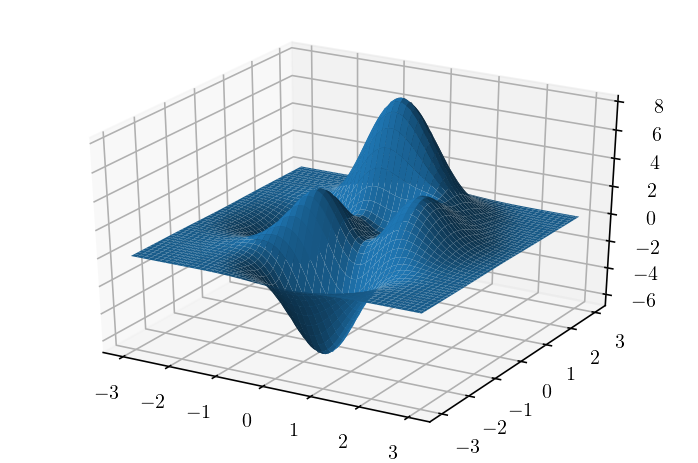

In [13]:
def peaks(nx, ny):
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-3, 3, ny)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2*np.exp(-(x**2) - (y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)
    x = None
    y = None
    gc.collect()
    return z


from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nx = 100
ny = 100
z = peaks(nx, ny)
x = np.linspace(-3, 3, nx)
y = np.linspace(-3, 3, ny)
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, z)

print(np.max(z), np.min(z))

In [14]:
width = 500000
height = 500000

domain_min = 16
domain_max = 1024
    
g = 9.81
r = 0.00

end_time = 1600.0

width = 500000
height = 500000

In [15]:
def averageFV(highres_solution, factor, symmetry=False):
    retval = highres_solution.copy().astype(np.float64)
    NX = retval.shape[1]
    NY = retval.shape[0]
    
    assert(NY % factor == 0)
    assert(NX % factor == 0)
    
    nx = int(NX / factor)
    ny = int(NY / factor)
    
    factor = int(factor)
    
    retval = retval.reshape([ny, factor, nx, factor]).mean(3).mean(1)
    if (symmetry):
        retval = 0.5*(retval +  retval[::-1, ::-1]) #Symmetry
    
    return retval.astype(np.float32)


def averageFD(highres_solution, factor, symmetry=False):
    retval = highres_solution.copy().astype(np.float64)
    target = retval.shape[0] / factor
    #while (retval.shape[0] > (target+1)):
    for i in range(int(np.log2(factor))):
        retval = retval[::2, ::2]
    if (symmetry):
        retval = 0.5*(retval +  retval[::-1, ::-1]) #Symmetry
    
    return retval.astype(np.float32)

def addGhosts(highres_solution):
    NX = highres_solution.shape[1] + 4
    NY = highres_solution.shape[0] + 4
    
    retval = np.empty((NY, NX), dtype=np.float32)    
    retval[2:-2, 2:-2] = highres_solution
    retval[0,:] = retval[3,:]
    retval[1,:] = retval[2,:]
    retval[-2,:] = retval[-3,:]
    retval[-1,:] = retval[-4,:]
    retval[:,0] = retval[:,3]
    retval[:,1] = retval[:,2]
    retval[:,-2] = retval[:,-3]
    retval[:,-1] = retval[:,-4]
    
    return retval

FV: Max=0.99999, min=0.00000, sum=344.3748450219
FV: Max=0.99999, min=0.00000, sum=86.0937112555
FV: Max=0.99999, min=0.00000, sum=21.5234278139
FV: Max=0.99999, min=0.00000, sum=5.3808569535
Angle: Max=0.98279, min=0.58800, sum=3216.9908772759
Angle: Max=0.98279, min=0.58800, sum=804.2477193190
Angle: Max=0.98279, min=0.58800, sum=201.0619298297
Angle: Max=0.98279, min=0.58800, sum=50.2654824574


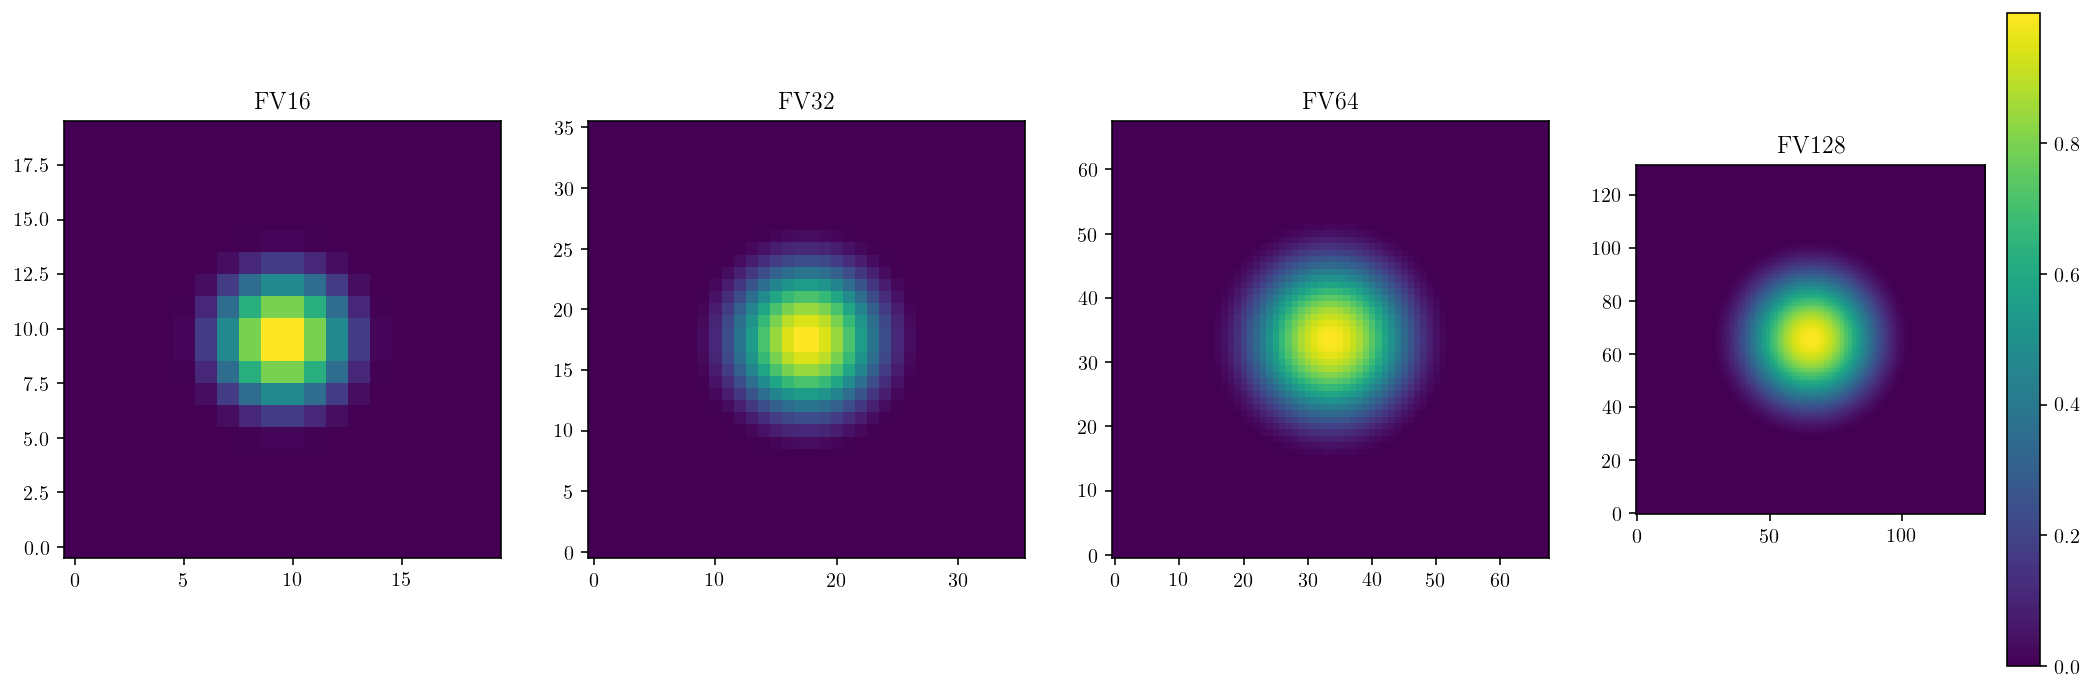

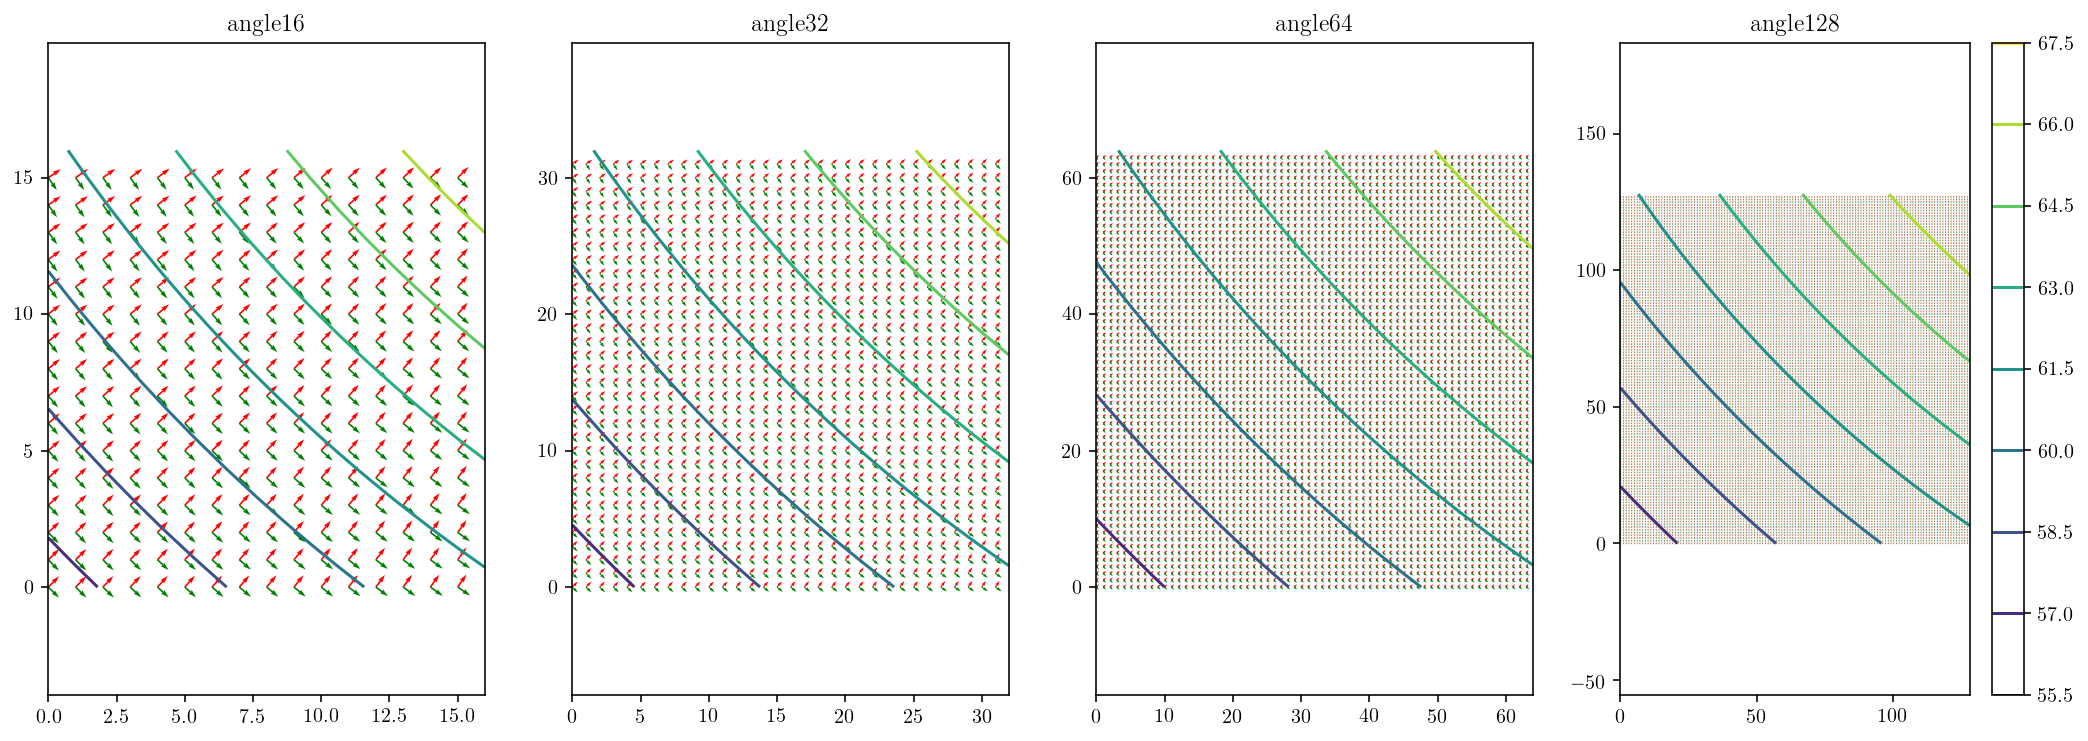

In [16]:
def initH(h0):
    nx = h0.shape[1]
    ny = h0.shape[0]
    
    h0 = 100 + 10*peaks(nx, ny)
    
    return h0

def initAngleLatitude(angle, latitude):
    nx = angle.shape[1]
    ny = angle.shape[0]
    
    x = np.linspace(0, 20000, nx)
    y = np.linspace(0, 20000, ny)

    x, y = np.meshgrid(x, y)

    x0, y0 = 3.0*20000, 3.0*20000
    x, y = x0-x, y0-y

    angle = np.arctan2(x, y)
    lat = 90-np.sqrt(x**2 + y**2)/2500
    
    return angle, lat
    
    
def initEtaFV(eta0):
    nx = eta0.shape[1]
    ny = eta0.shape[0]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i + 0.5 - nx/2.0) / float(nx)
        y = 2*(j + 0.5 - ny/2.0) / float(ny)
        r = np.sqrt(x**2 + y**2)
        return (1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    eta0 = 0.5 * np.fromfunction(lambda i, j: my_cos(i,j), (ny, nx))
    
    #Make sure solution is symmetric
    
    disturbance = None
    gc.collect()
    
    return eta0
    

    
def initHU(hu0):
    hu0.fill(0.0)
    return hu0
    
def initHV(hv0):
    hv0.fill(0.0)
    return hv0

    
plt.figure(figsize=(18,6))
eta0 = np.zeros((domain_max, domain_max), dtype=np.float32)
eta0 = initEtaFV(eta0)
for i in range(4):
    domain_size = domain_min*2**i
    plt.subplot(1, 4, i+1)
    plt.imshow(addGhosts(averageFV(eta0, domain_max//domain_size)), interpolation='nearest', origin='lower')
    plt.title("FV"+str(domain_size))
    print("FV: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
plt.colorbar()
    
plt.figure(figsize=(18,6))
angle = np.empty((domain_max, domain_max))
lat = np.empty((domain_max, domain_max))
angle, lat = initAngleLatitude(angle, lat)
for i in range(4):
    domain_size = domain_min*2**i
    plt.subplot(1, 4, i+1)
    #plt.imshow(angle, interpolation='nearest', origin='lower')
    #plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8)
    a = averageFV(angle, domain_max//domain_size)
    l = averageFV(lat, domain_max//domain_size)
    plt.quiver(np.sin(a), np.cos(a), color='r')
    plt.quiver(np.cos(a), -np.sin(a), color='g')
    plt.contour(l, extent=[0, domain_size, 0, domain_size])
    plt.axis('equal')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
plt.colorbar()
    

    

In [17]:
def plotData(eta0, u0, v0, eta1, u1, v1):
    fig, axarr = plt.subplots(2, 3, figsize=(12, 8))
    axarr[0, 0].imshow(eta0, interpolation="nearest")
    axarr[0, 1].imshow(u0, interpolation="nearest")
    axarr[0, 2].imshow(v0, interpolation="nearest")
    axarr[1, 0].imshow(eta1, interpolation="nearest")
    axarr[1, 1].imshow(u1, interpolation="nearest")
    axarr[1, 2].imshow(v1, interpolation="nearest")
    print("Eta0: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta0), np.min(eta0)))
    print("Eta1: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta1), np.min(eta1)))

In [18]:
def plotError(eta, eta_ref):
    max_eta = max(eta.max(), eta_ref.max())
    min_eta = min(eta.min(), eta_ref.min())
    
    err = eta - eta_ref
    max_err = max(abs(err.max()), abs(err.min()))
    
    ax1 = plt.subplot(1,3,1)
    plt.imshow(eta, vmax=max_eta, vmin=min_eta)
    plt.colorbar(shrink=0.9)
    ax1.set_title("Eta")

    ax2 = plt.subplot(1,3,2)
    plt.imshow(eta_ref, vmax=max_eta, vmin=min_eta)
    plt.colorbar(shrink=0.9)
    ax2.set_title("Eta ref")

    ax3 = plt.subplot(1,3,3)
    plt.imshow(err, vmax=max_err, vmin=-max_err, cmap="bwr")
    plt.colorbar(shrink=0.9)
    ax3.set_title("Error")

In [19]:
def computeError(filename, downsampler, order=1, plot=False):
    error = None
    domain_sizes = None
    with np.load(filename) as npzfile:
        #Get all domain sizes in file
        domain_sizes = np.array(list(npzfile.keys()), dtype=np.int)
        error = np.zeros(len(domain_sizes)-1)

        #Get largest domain size and remove (reference domain size)
        reference_domain_size = np.max(domain_sizes)
        domain_sizes = np.delete(domain_sizes, np.where(domain_sizes == reference_domain_size))

        #Get reference
        eta1_ref_disk = npzfile[str(reference_domain_size)].astype(np.float64)

        #Loop over all other domain sizes and compute the error
        for l, domain_size in enumerate(domain_sizes):
            #Get simulation
            eta1 = npzfile[str(domain_size)].astype(np.float64)

            #Downsample reference to simulation size
            eta1_ref = downsampler(eta1_ref_disk.copy(), reference_domain_size/domain_size)
            
            if (plot==True):
                plt.figure(figsize=(16,4))#, dpi=300)
                plotError(eta1, eta1_ref)
                plt.suptitle(filename)

            #Compute error 
            area = 1.0 / (domain_size*domain_size)
            if (order == 1):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) * area
            elif (order == 2):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) * np.sqrt(area)
            elif (order == np.inf):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) 
        
    return domain_sizes, error


## CDKLM 16

In [20]:
def benchmarkCDKLM(cdklm_filename, plot=True):
    
    
    #Run all domain sizes 
    data = {'domain_size': [], 't_dl': [], 't_sim': []};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    print("Using reference domain size " + str(reference_domain_size))
        
    #Allocate data
    Hi_ref = np.zeros((reference_domain_size+1, reference_domain_size+1), dtype=np.float32)
    eta0_ref = np.zeros((reference_domain_size, reference_domain_size), dtype=np.float32);
    #hu0_ref = np.zeros((reference_domain_size, reference_domain_size), dtype=np.float32);
    #hv0_ref = np.zeros((reference_domain_size, reference_domain_size), dtype=np.float32);
    angle_ref = np.zeros((128, 128), dtype=np.float32);
    lat_ref = np.zeros((128, 128), dtype=np.float32)
    
    #Initialize
    Hi_ref = initH(Hi_ref)
    eta0_ref = initEtaFV(eta0_ref)
    #hu0_ref = initHU(hu0_ref)
    #hv0_ref = initHV(hv0_ref)
    angle_ref, lat_ref = initAngleLatitude(angle_ref, lat_ref)
    
    
    def runCDKLM(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'cdklm_sim' in globals():
            cdklm_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)
        dt = end_time / domain_size
        
        Hi = addGhosts(averageFD(Hi_ref, reference_domain_size//domain_size))
        eta0 = addGhosts(averageFV(eta0_ref, reference_domain_size//domain_size))
        hu0 = np.zeros_like(eta0)
        hv0 = np.zeros_like(eta0)
        angle = angle_ref.copy()
        lat = lat_ref.copy()
        
        #Initialize simulator
        cdklm_sim = CDKLM16.CDKLM16(gpu_ctx, 
                      eta0, hu0, hv0, Hi, 
                      nx, ny, 
                      dx, dy, dt, 
                      g, 0.0, #f=0.0, calculated from latitude
                      r,
                      angle=angle, latitude=lat)
        
       
        
        t = cdklm_sim.step(end_time)
        eta1, hu1, hv1 = cdklm_sim.download()
        Hi, Hm = cdklm_sim.downloadBathymetry()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}, Hi=[{:f}, {:f}]".format(domain_size, t, cdklm_sim.num_iterations, np.min(eta1), np.max(eta1), np.min(Hi), np.max(Hi)))
        
        if (plot==True):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(25, 45)
            ax.pbaspect = [2.0, 2.0, 0.25]
            x = np.linspace(0, nx*dx, nx)/1000
            y = np.linspace(0, ny*dy, ny)/1000
            x, y = np.meshgrid(x, y)
            
            ls = colors.LightSource(270, 5)
            
            eps = 0.0
            
            ax.plot_surface(x, y, eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_ncar, edgecolor=None, shade=True, alpha=0.7, vmin=0, vmax=0.7, lightsource=ls)
            ax.contour(x, y, eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-1.0, 1.0, 20)+eps)
            
            ax.plot_surface(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_earth, edgecolor=None, shade=True, alpha=0.9, lightsource=ls)
            ax.contour(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-180, -40, 14)+eps)
            
            #ax.set_xlabel('km')
            #ax.set_ylabel('km')
            #ax.set_zlabel('m')
            
            plt.savefig(imgdir + "/3d_" + str(nx) + ".pdf")
            
            
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(25, 45)
            ax.pbaspect = [2.0, 2.0, 0.25]
            x = np.linspace(0, nx*dx, nx)/1000
            y = np.linspace(0, ny*dy, ny)/1000
            x, y = np.meshgrid(x, y)
            
            ls = colors.LightSource(270, 5)
            
            eps = 0.0
            
            ax.plot_surface(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_ncar, edgecolor=None, shade=True, alpha=0.7, vmin=0, vmax=0.7, lightsource=ls)
            ax.contour(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-1.0, 1.0, 20)+eps)
            
            ax.plot_surface(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_earth, edgecolor=None, shade=True, alpha=0.9, lightsource=ls)
            ax.contour(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-180, -40, 14)+eps)
            
            #ax.set_xlabel('km')
            #ax.set_ylabel('km')
            #ax.set_zlabel('m')
            
            plt.savefig(imgdir + "/3d_fin_" + str(nx) + ".pdf")

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    while (domain_size <= domain_max):
        [_, _, _, eta1, _, _] = runCDKLM(domain_size, reference_domain_size)
        data[str(domain_size)] = eta1
        domain_size = domain_size*2

    #Save to file
    np.savez_compressed(cdklm_filename, **data)
    
    
cdklm_filename = imgdir + "/CDKLM_data.npz"
benchmarkCDKLM(cdklm_filename)

Using reference domain size 2048


Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/andreb/miniconda3/envs/gpuocean/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-74c19fec616f>", line 151, in <module>
    benchmarkCDKLM(cdklm_filename)
  File "<ipython-input-20-74c19fec616f>", line 142, in benchmarkCDKLM
    [_, _, _, eta1, _, _] = runCDKLM(domain_size, reference_domain_size)
  File "<ipython-input-20-74c19fec616f>", line 44, in runCDKLM
    times += [time.time()]
NameError: name 'time' is not defined
Popping <94107880374576>
Pushing <94107880374576>


NameError: name 'time' is not defined

In [ ]:
domain_sizes, error = computeError(cdklm_filename, averageFV, plot=False, order=1)        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')
plt.title("L1 error")

In [ ]:
def find_numerical_order(data):
    num_intervals = len(data[0])-1
    order = np.empty(num_intervals)
    for i in range(num_intervals):
        x0 = data[0][i]
        x1 = data[0][i+1]
        y0 = data[1][i]
        y1 = data[1][i+1]
        order[i] = -np.log(y1/y0) / np.log(x1/x0)
        
    return np.median(np.array(order)), order

#fig = plt.figure()
fig = plt.figure(figsize=(4, 3), dpi=150)
setBwStyles(fig.gca())
#plt.gca().axis('equal')
min_x = domain_min
max_x = domain_max/2
min_scale = 3.0e-3 * min_x * min_x 
max_scale = 7.0e-2 * min_x 
x = np.linspace(min_x, max_x, 4)
plt.loglog(x, max_scale/x, '--', color='gray', label='Order 1')
plt.loglog(x, min_scale/(x*x), ':', color='gray', label='Order 2')

order_str = {1: '$L_1$', 2: "$L_2$", np.inf: "$L_{\inf}$"}


for order in [1, 2, np.inf]:
    cdklm_data = computeError(cdklm_filename, averageFV, order=order)

    plt.loglog(cdklm_data[0], cdklm_data[1], label=order_str[order])
    cdklm_order, _ = find_numerical_order(cdklm_data)
    plt.xticks(cdklm_data[0], ["$" + str(s) + "^2$" for s in cdklm_data[0]])
    
    print("------ order " + str(order) + " ----------")
    print("CDKLM: " + str(cdklm_order))

    plt.legend()

    plt.xlabel("Number of cells")
    plt.ylabel("Error")
    
    
l1 = computeError(cdklm_filename, averageFV, order=1)
l2 = computeError(cdklm_filename, averageFV, order=2)
linf = computeError(cdklm_filename, averageFV, order=np.inf)

_, l1_order = find_numerical_order(l1)
_, l2_order = find_numerical_order(l2)
_, linf_order = find_numerical_order(linf)
    
for i in range(len(l1[0])):
    
    if (i>0):
        print("${0:d}^2$ & {1:f} & {2:f} & {3:f} & {4:f} & {5:f} & {6:f} \\\\".format(
            l1[0][i], l1[1][i], l1_order[i-1], l2[1][i], l2_order[i-1], linf[1][i], linf_order[i-1]))
    else:
        print("${0:d}^2$ & {1:f} & - & {3:f} & - & {5:f} & - \\\\".format(
            l1[0][i], l1[1][i], 0, l2[1][i], 0, linf[1][i], 0))
    
    

plt.savefig(imgdir + "/convergence.pdf")    

In [ ]:
print(imgdir)